In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# -- 載入 Iris 資料集 --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)  # 樣本數

In [3]:
# -- 將訓練樣本做標準化 (standardization) x_std=(x-mean)/sigma 處理 --
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

In [4]:
# -- 將標籤 (正確答案) 做 one-hot 編碼 --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [5]:
# -- 將資料集拆分為「訓練資料集」與「測試資料集」 --
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test  = index[index%2 != 0]

In [6]:
input_train = input_data[index_train, :]  # 輸入
correct_train = correct_data[index_train, :]  # 正確答案
input_test = input_data[index_test, :]  # 輸入
correct_test = correct_data[index_test, :]  #  正確答案

In [7]:
n_train = input_train.shape[0]  # 訓練資料的樣本數 (75)
n_test = input_test.shape[0]  # 測試資料的樣本數 (75)

In [8]:
# -- 各設定値 --
n_in = 4  # 輸入層的神經元數量
n_mid = 25  # 中間層的神經元數量
n_out = 3  # 輸出層的神經元數量

In [9]:
wb_width = 0.1  # 設定權重參數的初始值乘上 0.01
eta = 0.01  # 學習率 (eta)
epoch = 1000
batch_size = 8
interval = 100

In [10]:
# -- 父類別 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # 權重矩陣
        self.b = wb_width * np.random.randn(n)  # 偏值向量
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [11]:
# -- 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLU的微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [12]:
# -- 輸出層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # Softmax

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [13]:
# -- 各層的實體化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [14]:
# -- 前向傳播 --
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

In [15]:
# -- 反向傳播 --
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)

In [16]:
# -- 修正權重參數 --
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

In [17]:
# -- 計算誤差 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size  # 交叉熵誤差

In [18]:
# -- 開始訓練 --

# -- 記錄誤差用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [19]:
# -- 記錄學習與進度--
n_batch = n_train // batch_size  # 每 1 epoch 的批次數量

In [20]:
for i in range(epoch):
    
    # -- 計算誤差 --  
    forward_propagation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    # -- 記錄誤差 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 顯示進度 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
       
    
    # -- 訓練 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # 索引洗牌
    for j in range(n_batch):
        
        # 取出小批次
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 前向傳播與反向傳播
        forward_propagation(x)
        backpropagation(t)
        
        # 更新權重與偏值
        update_wb()

Epoch:0/1000 Error_train:1.1114476759861853 Error_test:1.1108610271450463
Epoch:100/1000 Error_train:0.022634301587205797 Error_test:0.080711226442215
Epoch:200/1000 Error_train:0.007082266849288496 Error_test:0.10814342783095876
Epoch:300/1000 Error_train:0.0031367578360944324 Error_test:0.13784742589366655
Epoch:400/1000 Error_train:0.0017461678650282438 Error_test:0.15871466791671568
Epoch:500/1000 Error_train:0.0011671465946089528 Error_test:0.17510930958589152
Epoch:600/1000 Error_train:0.0008548048044609476 Error_test:0.18751092231556626
Epoch:700/1000 Error_train:0.0006605634357215745 Error_test:0.19841596996716804
Epoch:800/1000 Error_train:0.0005321051884836344 Error_test:0.20701969675597387
Epoch:900/1000 Error_train:0.00044201066227096854 Error_test:0.21511530641262988


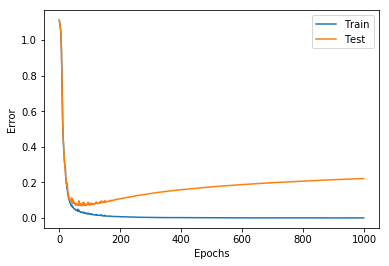

In [21]:
# -- 以圖表顯示誤差記錄 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [22]:
# -- 計算準確率 -- input_train
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

In [23]:
# -- 計算準確率 -- input_test
forward_propagation(input_test)
print(output_layer.y.shape)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

(75, 3)


In [24]:
print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

Accuracy Train: 100.0% Accuracy Test: 96.0%
